In [113]:
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pyplot as plt
import pywt
import os
import time

In [3]:
for dirname, _, filenames in os.walk('.\data'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

.\data\labels.txt
.\data\P812_M050_2_B_FoG_trial1_annotation.csv
.\data\P812_M050_2_B_FoG_trials.mat
.\data\P812_M050_2_B_FoG_trial_1_emg.csv
.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_1_out_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_emg.csv
.\data\P812_M050_2_B_FoG_trial_2_out_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_left_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_lower_right_foot.csv
.\data\P812_M050_2_B_FoG_trial_2_out_right_foot.csv
.\data\P812_M50_2_B_FoG_trial2_annotation.csv


In [4]:
emg_data = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_emg.csv')
t1olf = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_1_out_left_foot.csv')
emg_data2 = pd.read_csv('.\data\P812_M050_2_B_FoG_trial_2_emg.csv')

In [5]:
emg_data = emg_data.fillna({'LEFT_BF':emg_data.LEFT_BF.mean(),
                           'LEFT_RF':emg_data.LEFT_RF.mean(),
                           'RIGHT_TA':emg_data.RIGHT_TA.mean(),
                           'RIGHT_TS':emg_data.RIGHT_TS.mean(),
                           'RIGHT_BF':emg_data.RIGHT_BF.mean(),
                           'RIGHT_RF':emg_data.RIGHT_RF.mean()})
emg_data.isna().sum()

Time        0
Label1      0
Label2      0
LEFT_TA     0
LEFT_TS     0
LEFT_BF     0
LEFT_RF     0
RIGHT_TA    0
RIGHT_TS    0
RIGHT_BF    0
RIGHT_RF    0
dtype: int64

In [115]:
def generate_window_slide_data(data,width = 260, stride = 30):
    l = len(data)
    end = (l-width)//stride+1
    X = []
    Y = []
    for i in range(end):
        if len(set(data.Label2[i*stride:i*stride+width])) == 1:
                Y += [data.Label2[i*stride]]
                X += [np.array(data.iloc[i*stride:i*stride+width,3:])]
            #print(set(data.Label2[i*stride:i*stride+width]))
        else:
            #print(set(data.Label2[i*stride:i*stride+width]))
            continue
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.uint8)

#def generate_CWT_feature(data,widths=260,wavelet = signal.ricker):
#    n,t,c = data.shape
#    cwtmatr = np.zeros((n,widths,t,c))
#    for i in range(n):
#        for j in range(c):
#            cwtmatr[i,:,:,j] = signal.cwt(data[i,:,j],wavelet,np.arange(1,widths+1))
#    return cwtmatr


def generate_CWT_feature(data,widths=260,wavelet = 'mexh'):
    n,t,c = data.shape
    cwtmatr = np.zeros((n,widths,t,c))
    for i in range(n):
        for j in range(c):
            cwtmatr[i,:,:,j],_ = pywt.cwt(data[i,:,j],np.arange(1,widths+1),wavelet)
    return cwtmatr

In [178]:
width = 256
stride = 32
widths_scale = 32
x,y = generate_window_slide_data(emg_data,width,stride)

In [179]:
x = (x-x.min())/(x.max()-x.min())

In [53]:
(np.isnan(cwtmatr)).sum()
cwtmatr.max()

10774.61668333365

In [119]:
pywt.wavelist(kind='continuous')

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']

In [180]:
start = time.time()
cwtmatr = generate_CWT_feature(x,widths_scale,'mexh')
end = time.time()
duration = end-start
print('duration: %f'%(duration))

duration: 51.549625


In [12]:
import h5py

file = './processed data/P812_trial_1_W%d_S%d_WS%d_CWT.hdf5'%(width,stride,widths_scale)
with h5py.File(file,'w') as f:
    f.create_dataset('cwt_data',data=cwtmatr, maxshape=(None,260,260,8),
                     chunks = True,dtype = np.float32)
    f.create_dataset('label2',data=y, dtype = np.int8)

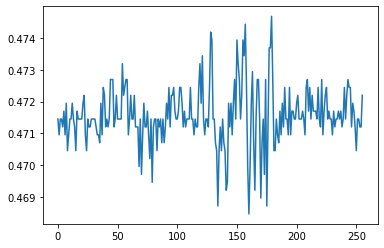

In [71]:
plt.plot(x[1,:,1])

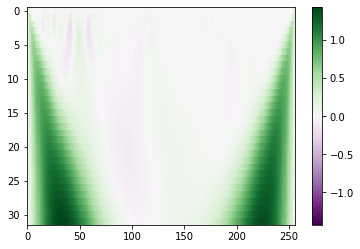

2


In [193]:
temp = 600
channel = 0
plt.imshow(cwtmatr[temp,:,:,channel], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr[temp,:,:,channel]).max(), 
           vmin=-abs(cwtmatr[temp,:,:,channel]).max())
plt.colorbar()
plt.show()
print(y[temp])

In [156]:
#label = y[ind]
#label[label==2]=1


In [31]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import save_model
from tensorflow.keras import callbacks, Model
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import ELU
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import backend as K

In [194]:
cwtmatr = tf.random.shuffle(cwtmatr,seed=60)
y = tf.random.shuffle(y,seed=60)

In [204]:
input_ = layers.Input(shape=cwtmatr.shape[1:])
#max_pool = layers.MaxPooling2D(2)(input_)
conv1 = layers.Conv2D(64,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(input_)
max_pool1 = layers.MaxPooling2D(2)(conv1)
conv2 = layers.Conv2D(128,5,strides=(2,2),kernel_initializer=TruncatedNormal(),activation='relu',padding='same')(max_pool1)
max_pool2 = layers.MaxPooling2D(2)(conv2)
flatten = layers.Flatten()(max_pool2)
#layer1 = Dense(256,activation = 'relu')(flatten)
dropout1 = layers.Dropout(0.2)(flatten)
layer2 = layers.Dense(128,activation = 'relu')(dropout1)
dropout2 = layers.Dropout(0.2)(layer2)
output = layers.Dense(2,activation = 'softmax')(dropout2)
model = keras.Model(inputs=[input_],outputs=[output])

In [205]:
ind = ((y==0) | (y==2))
bce = CategoricalCrossentropy()
model.compile(loss =bce ,optimizer='adam',metrics=['accuracy'])
oh_ec = OneHotEncoder()
label = oh_ec.fit_transform(K.eval(y)[ind,tf.newaxis]).toarray()

In [206]:
early_stopping = callbacks.EarlyStopping(patience = 20,monitor = 'val_accuracy', restore_best_weights=True)

In [207]:
history = model.fit(cwtmatr[ind],label,validation_split=0.2,
                    epochs=100,batch_size=50,
                   callbacks=[early_stopping])

Train on 1467 samples, validate on 367 samples
Epoch 1/100
1467/1467 [==============================] - 11s 8ms/sample - loss: 0.6161 - accuracy: 0.7096 - val_loss: 0.5004 - val_accuracy: 0.8338
Epoch 2/100
1467/1467 [==============================] - 9s 6ms/sample - loss: 0.5088 - accuracy: 0.7853 - val_loss: 0.4246 - val_accuracy: 0.8283
Epoch 3/100
1467/1467 [==============================] - 10s 7ms/sample - loss: 0.4696 - accuracy: 0.8023 - val_loss: 0.4371 - val_accuracy: 0.8338
Epoch 4/100
1467/1467 [==============================] - 9s 6ms/sample - loss: 0.4509 - accuracy: 0.8098 - val_loss: 0.4083 - val_accuracy: 0.8283
Epoch 5/100
1467/1467 [==============================] - 9s 6ms/sample - loss: 0.4180 - accuracy: 0.8132 - val_loss: 0.3962 - val_accuracy: 0.8093
Epoch 6/100
1467/1467 [==============================] - 9s 6ms/sample - loss: 0.3879 - accuracy: 0.8173 - val_loss: 0.3464 - val_accuracy: 0.8447
Epoch 7/100
1467/1467 [==============================] - 9s 6ms/sampl

Epoch 56/100
1467/1467 [==============================] - 11s 7ms/sample - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.1580 - val_accuracy: 0.9700
Epoch 57/100
1467/1467 [==============================] - 10s 7ms/sample - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.1677 - val_accuracy: 0.9591
Epoch 58/100
1467/1467 [==============================] - 9s 6ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9755
Epoch 59/100
1467/1467 [==============================] - 10s 7ms/sample - loss: 0.0047 - accuracy: 0.9980 - val_loss: 0.2911 - val_accuracy: 0.9346
Epoch 60/100
1467/1467 [==============================] - 8s 5ms/sample - loss: 0.0117 - accuracy: 0.9945 - val_loss: 0.0999 - val_accuracy: 0.9837
Epoch 61/100
1467/1467 [==============================] - 8s 5ms/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.1017 - val_accuracy: 0.9782
Epoch 62/100
1467/1467 [==============================] - 8s 5ms/sample - loss: 0.0127 - accuracy: 0.9959 - v

In [50]:
y_pred = model.predict(cwtmatr[:3])
y_pred

array([[9.741865e-01, 2.581344e-02],
       [9.422290e-06, 9.999906e-01],
       [8.860579e-03, 9.911395e-01]], dtype=float32)

In [34]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 256, 8)]      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 128, 8)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 64, 64)        12864     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 32, 64)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 16, 128)        204928    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0   

(0, 1)

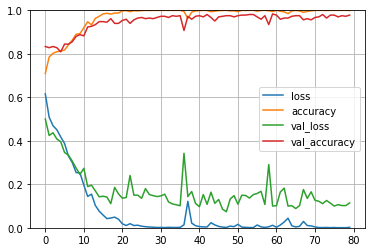

In [208]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)

In [203]:
model.save('Mexh_W%d_S%d_WS%d.h5'%(width,stride,widths_scale))